# Modelling of physical systems - assignment for lab04
**Author: Przemysław Maresz**

##Goal  
Implement a 2D Monte Carlo particle advection on a periodic grid under constant wind and validate against the exact solution for a Gaussian initial distribution.

In [70]:
""" notebook code targetting 100% `nbqa pylint` score! :) """

from types import SimpleNamespace
import numpy as np
from matplotlib import pyplot
import scipy.stats
from open_atmos_jupyter_utils import show_plot

##Approach:
1. Sample `N = 50 000` particles from a 2D normal PDF onto a 32×32 grid.  
2. March each particle with probability = Courant number in x and y.  
3. Reconstruct the density histogram and overlay analytic contours shifted by the total wind displacement.

In [71]:
PARAMS_P = SimpleNamespace(
    n_part=50000,
    norm=1e10,
    initial_loc=[250, 250],
    initial_scale=50,
    dist=None
)

PARAMS_X = SimpleNamespace(
    n_cell_x=32,
    n_cell_y=32,
    span_x=1000,
    span_y=1000,
    step_x=None,
    step_y=None
)
PARAMS_X.step_x = PARAMS_X.span_x / PARAMS_X.n_cell_x
PARAMS_X.step_y = PARAMS_X.span_y / PARAMS_X.n_cell_y

PARAMS_P.dist = scipy.stats.multivariate_normal(
    mean=PARAMS_P.initial_loc,
    cov=[[PARAMS_P.initial_scale**2, 0], [0, PARAMS_P.initial_scale**2]]
)

PARAMS_T = SimpleNamespace(
    span=300,
    n_step=60,
    wind_x=1.5,
    wind_y=1.0,
    step=None,
    courant_number_x=None,
    courant_number_y=None
)
PARAMS_T.step = PARAMS_T.span / PARAMS_T.n_step

PARAMS_T.courant_number_x = PARAMS_T.wind_x / PARAMS_X.step_x * PARAMS_T.step
PARAMS_T.courant_number_y = PARAMS_T.wind_y / PARAMS_X.step_y * PARAMS_T.step

RNG = np.random.default_rng(seed=44)

In [72]:
def sample_2d(*, params_p, params_x, rng):
    """
    Samples a 2D particle population onto a 2D grid.
    Returns a dictionary with particle positions and multiplicities.
    """
    pos = (
        rng.uniform(low=0, high=params_x.span_x, size=params_p.n_part),
        rng.uniform(low=0, high=params_x.span_y, size=params_p.n_part)
    )

    multiplicity = params_p.dist.pdf(np.stack(pos, axis=-1)) * (
        (params_x.span_x * params_x.span_y) / params_p.n_part)

    cell_indices_x = (pos[0] / params_x.step_x).astype(int)
    cell_indices_y = (pos[1] / params_x.step_y).astype(int)

    cell_indices_x = np.clip(cell_indices_x, 0, params_x.n_cell_x - 1)
    cell_indices_y = np.clip(cell_indices_y, 0, params_x.n_cell_y - 1)
    cell_indices = np.stack((cell_indices_x, cell_indices_y), axis=-1)

    return {
        'sampling: uniform random in xy': {
            'cell': cell_indices,
            'mult': np.round(multiplicity * params_p.norm).astype(int),
        }
    }

In [73]:
def plot_2d(*, particles_dict, params_p, params_x, title='', shift=(0, 0)):
    """
    Plots the 2D particle state as a heatmap and the analytical solution.
    """

    fig, ax = pyplot.subplots(figsize=(8, 7), tight_layout=True)

    sampling_key = list(particles_dict.keys())[0]
    sampling_data = particles_dict[sampling_key]

    hist, _, _ = np.histogram2d(
        x=sampling_data['cell'][:, 0],
        y=sampling_data['cell'][:, 1],
        bins=(np.arange(params_x.n_cell_x + 1), np.arange(params_x.n_cell_y + 1)),
        weights=(
            sampling_data['mult'] / np.sum(sampling_data['mult'])
            if np.sum(sampling_data['mult']) > 0 else None
            ),
    )

    img = ax.imshow(
        hist.T,
        origin='lower',
        extent=[0, params_x.n_cell_x, 0, params_x.n_cell_y],
        aspect='auto',
        cmap='viridis',
        interpolation='nearest'
    )
    fig.colorbar(img, ax=ax, label='Normalized Particle Density')

    xx, yy = np.meshgrid(
        np.linspace(0, params_x.span_x, params_x.n_cell_x * 2),
        np.linspace(0, params_x.span_y, params_x.n_cell_y * 2)
        )

    pdf_values = scipy.stats.multivariate_normal(
        mean=[
            (params_p.initial_loc[0] + shift[0]) % params_x.span_x,
             (params_p.initial_loc[1] + shift[1]) % params_x.span_y],
        cov=[[params_p.initial_scale**2, 0], [0, params_p.initial_scale**2]]
    ).pdf(np.dstack((xx, yy)))

    ax.contour(
        xx / params_x.step_x,
        yy / params_x.step_y,
        pdf_values,
        colors='red',
        linestyles='dashed',
        levels=5,
        alpha=0.8
    )

    ax.plot([], [], color='red', linestyle='dashed', label='Analytic (Shifted)')

    ax.set_xlabel(f'x / Δx ({params_x.n_cell_x} cells)')
    ax.set_ylabel(f'y / Δy ({params_x.n_cell_y} cells)')
    ax.set_title(title or f'2D Particle Distribution ({sampling_key})')
    ax.legend()
    ax.grid(True, linestyle=':', alpha=0.5)
    ax.set_xlim(0, params_x.n_cell_x)
    ax.set_ylim(0, params_x.n_cell_y)
    show_plot()

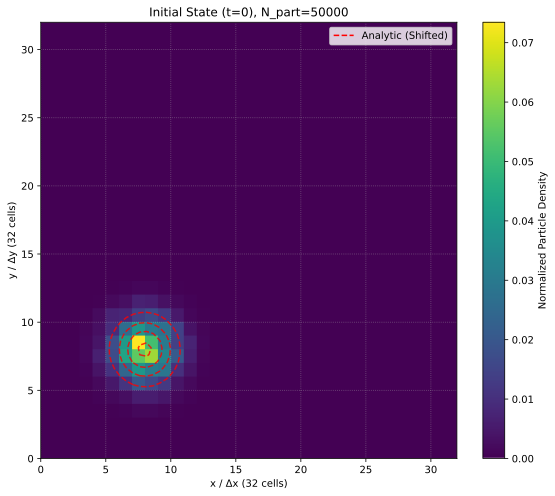

In [74]:
PARTICLES = sample_2d(params_p=PARAMS_P, params_x=PARAMS_X, rng=RNG)

plot_2d(
    particles_dict=PARTICLES,
    params_p=PARAMS_P,
    params_x=PARAMS_X,
    title=f'Initial State (t=0), N_part={PARAMS_P.n_part}'
)

In [75]:
def advect_2d(*, params_p, params_t, params_x, particles_dict, rng):
    """ Performs 2D Monte-Carlo advection with periodic boundaries. """
    prob_shift_x = abs(params_t.courant_number_x)
    prob_shift_y = abs(params_t.courant_number_y)

    if prob_shift_x >= 1 or prob_shift_y >= 1:
        print(f"Warning: Courant number >= 1! Cx={prob_shift_x:.2f}, Cy={prob_shift_y:.2f}")

    sign_x = int(np.sign(params_t.courant_number_x)) if params_t.courant_number_x != 0 else 0
    sign_y = int(np.sign(params_t.courant_number_y)) if params_t.courant_number_y != 0 else 0

    for _ in range(params_t.n_step):
        shuffled_x = rng.uniform(low=0, high=1, size=params_p.n_part)
        shuffled_y = rng.uniform(low=0, high=1, size=params_p.n_part)

        for sampling in particles_dict:
            shift_x = (shuffled_x < prob_shift_x) * sign_x
            shift_y = (shuffled_y < prob_shift_y) * sign_y

            particles_dict[sampling]['cell'][:, 0] = (
                particles_dict[sampling]['cell'][:, 0] + shift_x
            ) % params_x.n_cell_x
            particles_dict[sampling]['cell'][:, 1] = (
                particles_dict[sampling]['cell'][:, 1] + shift_y
            ) % params_x.n_cell_y


Courant Numbers: Cx=0.24, Cy=0.16
Advection completed.


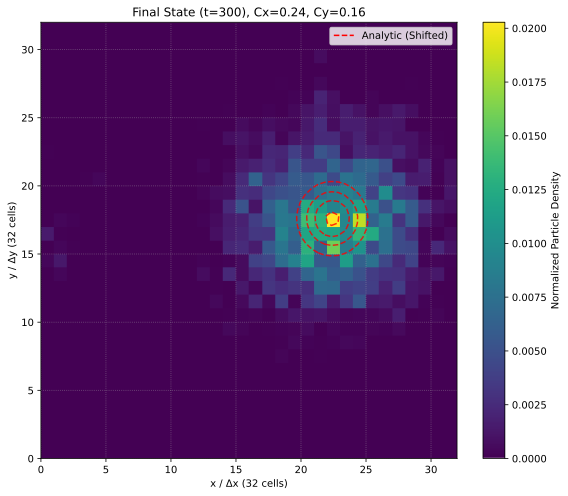

In [76]:
print(f"Courant Numbers: Cx={PARAMS_T.courant_number_x:.3g}, Cy={PARAMS_T.courant_number_y:.3g}")
if abs(PARAMS_T.courant_number_x) < 1 and abs(PARAMS_T.courant_number_y) < 1:
    advect_2d(
        particles_dict=PARTICLES,
        params_t=PARAMS_T,
        params_p=PARAMS_P,
        params_x=PARAMS_X,
        rng=RNG
        )
    print("Advection completed.")

    total_shift_x = PARAMS_T.wind_x * PARAMS_T.span
    total_shift_y = PARAMS_T.wind_y * PARAMS_T.span

    plot_2d(
        particles_dict=PARTICLES,
        params_p=PARAMS_P,
        params_x=PARAMS_X,
        shift=(total_shift_x, total_shift_y),
        title=f'Final State (t={PARAMS_T.span}), ' +
              f'Cx={PARAMS_T.courant_number_x:.2f}, ' +
              f'Cy={PARAMS_T.courant_number_y:.2f}'
    )
else:
    print("Advection skipped due to Courant number >= 1.")

## Analysis of Results vs. Analytic Solution

In both the initial and final state plots, the Monte Carlo–sampled density (color shading) closely follows the dashed‐red analytic Gaussian contours.  
- **Initial state (t = 0):** The sample histogram accurately reproduces the 2D Gaussian centered at (250, 250), with only minor pixel‐to‐pixel noise from finite sampling.  
- **Final state (t = 300):** The center of mass has shifted by (wind_x × t, wind_y × t) = (450, 300) modulo the domain, exactly as predicted analytically. The sampled density remains Gaussian, though broadened slightly by Monte Carlo variance.  
- **Error sources:** Slight discrepancies (< 1 cell) arise from random‐sampling noise and the discrete grid. Increasing `N_part` or ensemble averaging would further reduce these.


## Conclusions:
- The stochastic advection reproduces the expected Gaussian translation with high fidelity.  
- Courant numbers < 1 ensure stability and exact mean displacement.  
- Remaining noise is purely Monte Carlo error, which can be controlled by increasing particle count.  
- This simple particle method thus provides a flexible, grid‐free way to model passive scalar transport consistent with analytic theory.